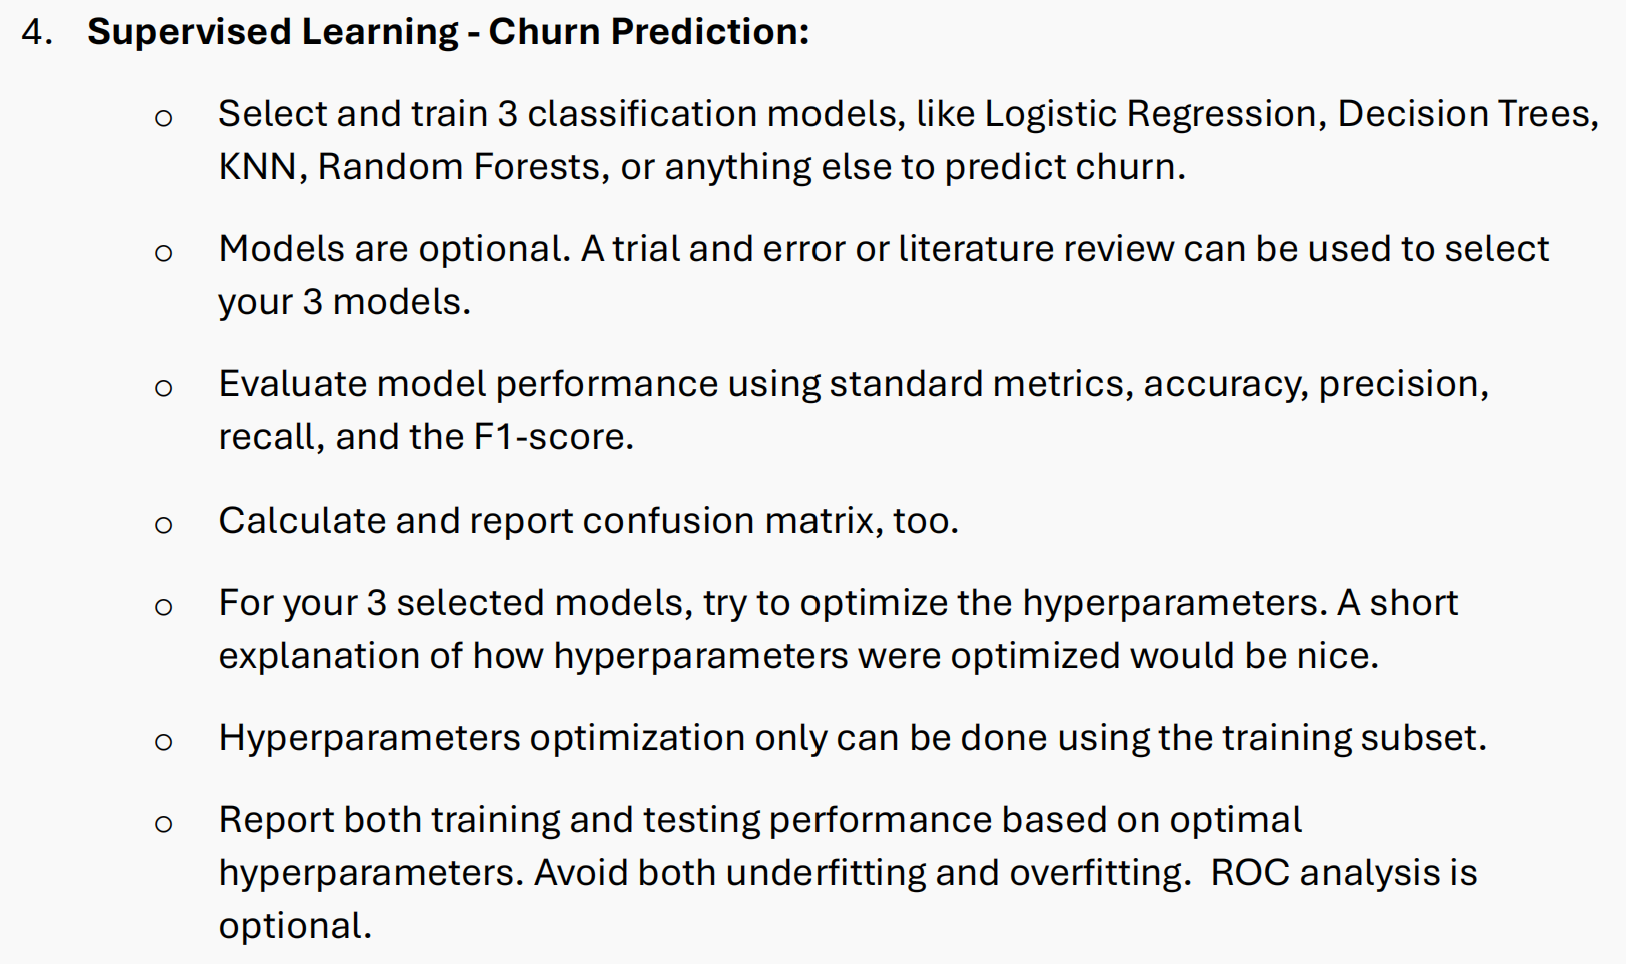

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier  
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    fbeta_score,
    confusion_matrix,
    make_scorer,
    RocCurveDisplay
)
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')

C:\Users\xiaoyicong\AppData\Roaming\Python\Python310\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## 1. Data Setup

- Loading data
- Separating `X_train` and `X_test`, `Y_train` and `Y_test`
- Creating an oversampled version of the training set, for comparison

In [4]:
train_dir = "encoded_train.csv"
test_dir = "encoded_test.csv"

In [5]:
train_df = pd.read_csv(train_dir)
test_df = pd.read_csv(test_dir)

In [7]:
test_df

,Account length,International plan,Voice mail plan,Total day calls,Total day charge,Total eve calls,Total eve charge,Total night calls,Total night charge,Total intl calls,...,State_UT,State_VA,State_VT,State_WA,State_WI,State_WV,State_WY,Area code_408,Area code_415,Area code_510
0,0.479339,0.0,0.0,0.60625,0.525989,0.470588,0.967001,0.428571,0.489873,0.20,...,False,False,False,False,False,False,False,True,False,False
1,0.264463,0.0,0.0,0.85625,0.368042,0.488235,0.628276,0.586466,0.470253,0.30,...,False,False,False,False,False,False,False,False,True,False
2,0.661157,0.0,0.0,0.41875,0.948860,0.570588,0.873827,0.714286,0.332911,0.45,...,False,False,False,False,False,False,False,False,True,False
3,0.454545,0.0,0.0,0.64375,0.314722,0.600000,0.377548,0.541353,0.415190,0.30,...,False,False,False,False,False,False,False,False,True,False
4,0.198347,0.0,0.0,0.73125,0.340040,0.641176,0.591394,0.428571,0.384177,0.05,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
662,0.466942,0.0,1.0,0.55000,0.390845,0.735294,0.428017,0.458647,0.580380,0.35,...,False,False,False,False,True,False,False,False,True,False
663,0.433884,0.0,1.0,0.81875,0.238263,0.770588,0.560660,0.300752,0.529114,0.15,...,False,False,False,False,False,False,False,True,False,False
664,0.243802,0.0,0.0,0.73750,0.552649,0.647059,0.233905,0.759398,0.473418,0.40,...,False,False,True,False,False,False,False,False,True,False
665,0.652893,0.0,0.0,0.71250,0.484071,0.617647,0.543513,0.368421,0.427215,0.20,...,False,False,False,False,False,True,False,False,True,False


In [4]:
train_df.head(5)

,Account length,International plan,Voice mail plan,Total day calls,Total day charge,Total eve calls,Total eve charge,Total night calls,Total night charge,Total intl calls,...,State_UT,State_VA,State_VT,State_WA,State_WI,State_WV,State_WY,Area code_408,Area code_415,Area code_510
0,0.524793,0.0,1.0,0.68750,0.755701,0.582353,0.542866,0.436090,0.572152,0.15,...,False,False,False,False,False,False,False,False,True,False
1,0.438017,0.0,1.0,0.76875,0.460597,0.605882,0.537690,0.526316,0.600000,0.15,...,False,False,False,False,False,False,False,False,True,False
2,0.561983,0.0,0.0,0.71250,0.693830,0.647059,0.333225,0.533835,0.338608,0.25,...,False,False,False,False,False,False,False,False,True,False
3,0.342975,1.0,0.0,0.44375,0.853454,0.517647,0.170171,0.421053,0.436076,0.35,...,False,False,False,False,False,False,False,True,False,False
4,0.305785,1.0,0.0,0.70625,0.475184,0.717647,0.407959,0.661654,0.407595,0.15,...,False,False,False,False,False,False,False,False,True,False


In [5]:
Y_column = "Churn"
X_columns = [col for col in train_df.columns if col != "Churn"]

X_train, y_train, X_test, y_test = (
    train_df[X_columns],
    train_df[Y_column],
    test_df[X_columns],
    test_df[Y_column],
)


# SMOTE
# Create an instance of the SMOTE oversampler
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

## 2. Model Training & Tuning
- Apply 5-fold stratified CV with Grid Search

In [7]:
RANDOM_STATE = 110

# models selected
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(random_state=RANDOM_STATE),
    "Gradient Boosting": GradientBoostingClassifier(random_state=RANDOM_STATE),
}

# Grid search setup
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

hyperparameters = {
    "Logistic Regression": {
        "C": [0.001, 0.01, 0.1, 1, 10, 100],
        "penalty": [None, "l1", "l2", "elasticnet"],
    },
    "Random Forest": {
        "n_estimators": [50, 100, 200],
        "max_depth": [None, 10, 20, 30],
    },
    "Gradient Boosting": {  
        "n_estimators": [50, 100, 200],
        "max_depth": [5, 10, 20, 30],
        "learning_rate": [0.01, 0.1, 0.2],
        "subsample": [0.5, 0.6, 0.7, 0.8, 1.0],
    },
}

In [8]:
def train_eval_model(model, X_train, X_test, y_train, y_test):
    """
    Trains model on train set, reports result on both train and test set
    """
    # Train
    model.fit(X_train, y_train)

    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Metrics
    metrics = {
        "Train Accuracy": accuracy_score(y_train, y_train_pred),
        "Test Accuracy": accuracy_score(y_test, y_test_pred),
        "Train Precision": precision_score(y_train, y_train_pred),
        "Test Precision": precision_score(y_test, y_test_pred),
        "Train Recall": recall_score(y_train, y_train_pred),
        "Test Recall": recall_score(y_test, y_test_pred),
        "Train F1": f1_score(y_train, y_train_pred),
        "Test F1": f1_score(y_test, y_test_pred),
        "Train F2": fbeta_score(y_train, y_train_pred, beta = 2),
        "Test F2": fbeta_score(y_test, y_test_pred, beta = 2),
        "Confusion Matrix": confusion_matrix(y_test, y_test_pred),
    }
    return metrics

In [9]:
# tuning entry point


tuned_models_regular = {}
tuned_models_smote = {}

for model_name in tqdm.tqdm(models):
    model = models[model_name]
    param_grid = hyperparameters[model_name]

    grid_search = GridSearchCV(
        model,
        param_grid,
        cv=cv_strategy,
        scoring = 'recall', #make_scorer(fbeta_score, beta=2),
        n_jobs=-1,
    )

    ### Original data
    grid_search.fit(X_train, y_train)
    tuned_models_regular[model_name] = grid_search.best_estimator_

    ### SMOTE data 
    grid_search.fit(X_train_smote, y_train_smote)
    tuned_models_smote[model_name] = grid_search.best_estimator_

100%|██████████| 3/3 [26:46<00:00, 535.57s/it]


## 3. Testing

In [10]:
# # Evaluate all models
results_regular = {}
for name, model in tuned_models_regular.items():
    results_regular[name] = train_eval_model(model, X_train, X_test, y_train, y_test)


results_smote = {}
for name, model in tuned_models_smote.items():
    results_smote[name] = train_eval_model(model, X_train_smote, X_test, y_train_smote, y_test)

In [11]:
def display_metrics(model_name, result_dict, comment = "w/o oversampling"):
    print(f"\n{model_name} Performance {comment}:")
    print(f"Train Accuracy: {result_dict['Train Accuracy']:.4f}")
    print(f"Test Accuracy: {result_dict['Test Accuracy']:.4f}")
    print(f"Train Precision: {result_dict['Train Precision']:.4f}")
    print(f"Test Precision: {result_dict['Test Precision']:.4f}")
    print(f"Train Recall: {result_dict['Train Recall']:.4f}")
    print(f"Test Recall: {result_dict['Test Recall']:.4f}")
    print(f"Train F1: {result_dict['Train F1']:.4f}")
    print(f"Test F1: {result_dict['Test F1']:.4f}")
    print(f"Train F2: {result_dict['Train F2']:.4f}")
    print(f"Test F2: {result_dict['Test F2']:.4f}")

    # Plot confusion matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(result_dict["Confusion Matrix"], annot=True, fmt="d", cmap="Blues")
    plt.title(f"{model_name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


Logistic Regression Performance w/o oversampling:
Train Accuracy: 0.8702
Test Accuracy: 0.8591
Train Precision: 0.6193
Test Precision: 0.5106
Train Recall: 0.2809
Test Recall: 0.2526
Train F1: 0.3865
Test F1: 0.3380
Train F2: 0.3154
Test F2: 0.2810


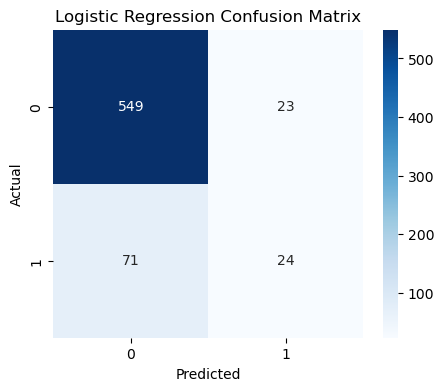


Random Forest Performance w/o oversampling:
Train Accuracy: 0.9940
Test Accuracy: 0.9415
Train Precision: 1.0000
Test Precision: 0.9828
Train Recall: 0.9588
Test Recall: 0.6000
Train F1: 0.9789
Test F1: 0.7451
Train F2: 0.9667
Test F2: 0.6507


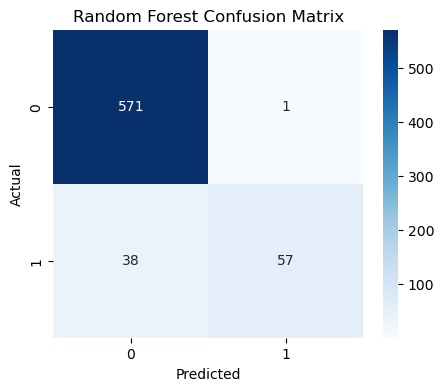


Gradient Boosting Performance w/o oversampling:
Train Accuracy: 1.0000
Test Accuracy: 0.9565
Train Precision: 1.0000
Test Precision: 0.8929
Train Recall: 1.0000
Test Recall: 0.7895
Train F1: 1.0000
Test F1: 0.8380
Train F2: 1.0000
Test F2: 0.8082


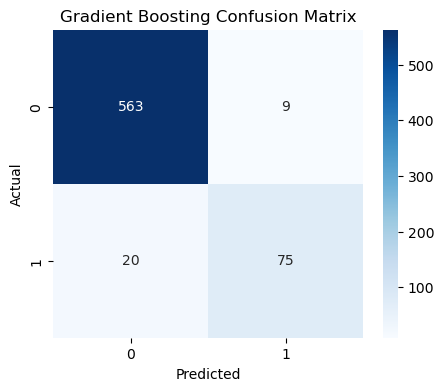

In [12]:
for name, result_dict in results_regular.items():
    display_metrics(name, result_dict)


Logistic Regression Performance with oversampling:
Train Accuracy: 0.8486
Test Accuracy: 0.8126
Train Precision: 0.8567
Test Precision: 0.3958
Train Recall: 0.8371
Test Recall: 0.6000
Train F1: 0.8468
Test F1: 0.4770
Train F2: 0.8410
Test F2: 0.5439


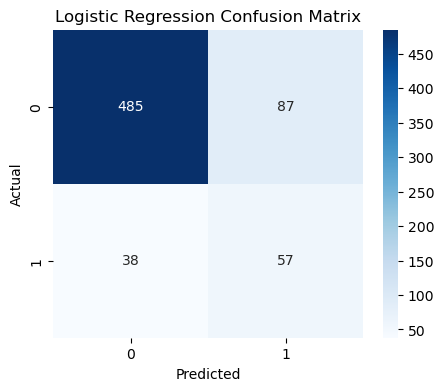


Random Forest Performance with oversampling:
Train Accuracy: 1.0000
Test Accuracy: 0.9280
Train Precision: 1.0000
Test Precision: 0.7582
Train Recall: 1.0000
Test Recall: 0.7263
Train F1: 1.0000
Test F1: 0.7419
Train F2: 1.0000
Test F2: 0.7325


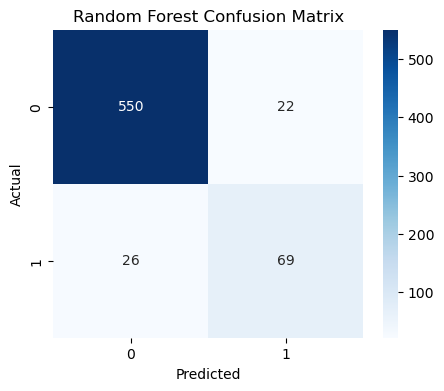


Gradient Boosting Performance with oversampling:
Train Accuracy: 1.0000
Test Accuracy: 0.9430
Train Precision: 1.0000
Test Precision: 0.8202
Train Recall: 1.0000
Test Recall: 0.7684
Train F1: 1.0000
Test F1: 0.7935
Train F2: 1.0000
Test F2: 0.7783


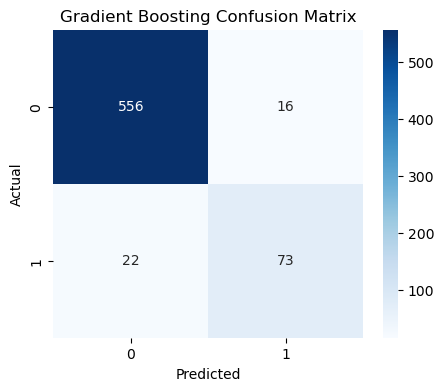

In [13]:
for name, result_dict in results_smote.items():
    display_metrics(name, result_dict, comment = "with oversampling")

## 4. Result Analysis

- Feature Importance Score for tree methods

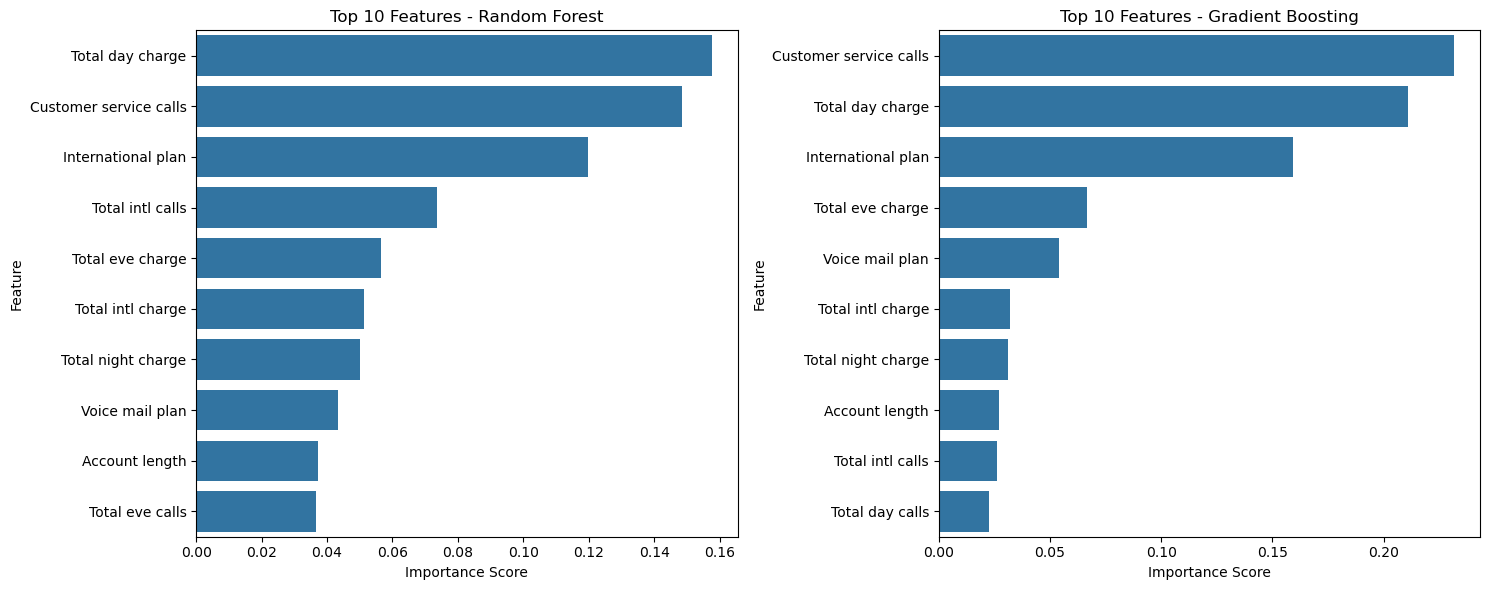

In [14]:
# Get feature importances from Random Forest
rf_model = tuned_models_smote["Random Forest"]
rf_importances = rf_model.feature_importances_
rf_feature_importance = pd.DataFrame({
    'Feature': X_columns,
    'Importance': rf_importances
}).sort_values('Importance', ascending=False)

# Get feature importances from Gradient Boosting
gb_model = tuned_models_smote["Gradient Boosting"]
gb_importances = gb_model.feature_importances_
gb_feature_importance = pd.DataFrame({
    'Feature': X_columns,
    'Importance': gb_importances
}).sort_values('Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
sns.barplot(x='Importance', y='Feature', data=rf_feature_importance.head(10))
plt.title('Top 10 Features - Random Forest')
plt.xlabel('Importance Score')

plt.subplot(1, 2, 2)
sns.barplot(x='Importance', y='Feature', data=gb_feature_importance.head(10))
plt.title('Top 10 Features - Gradient Boosting')
plt.xlabel('Importance Score')

plt.tight_layout()
plt.show()

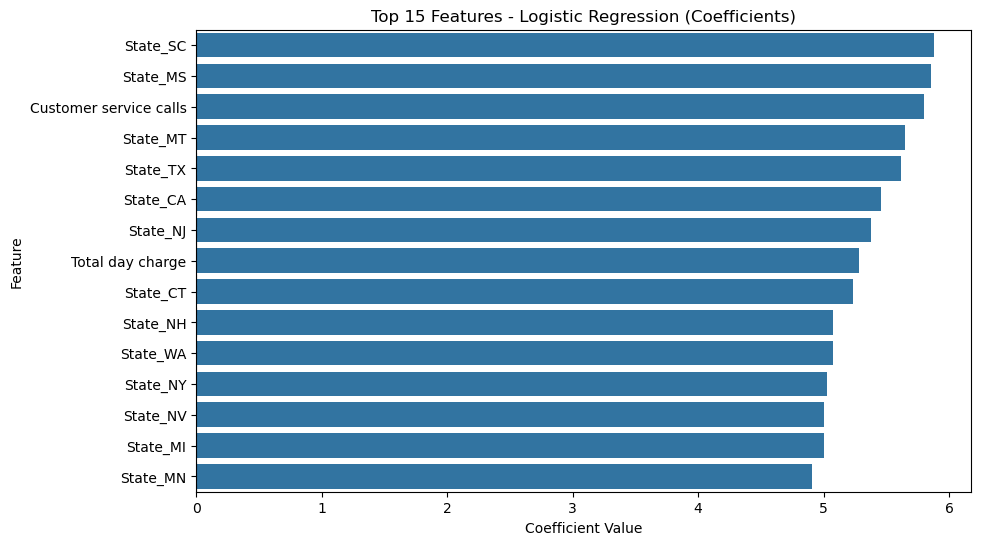

In [15]:
# Get coefficients from Logistic Regression
lr_model = tuned_models_smote["Logistic Regression"]
lr_coefficients = lr_model.coef_[0]
lr_feature_importance = pd.DataFrame({
    'Feature': X_columns,
    'Coefficient': lr_coefficients,
    'Absolute_Coefficient': np.abs(lr_coefficients)
}).sort_values('Absolute_Coefficient', ascending=False)

# Plot logistic regression coefficients
plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=lr_feature_importance.head(15))
plt.title('Top 15 Features - Logistic Regression (Coefficients)')
plt.xlabel('Coefficient Value')
plt.axvline(x=0, color='k', linestyle='--')
plt.show()

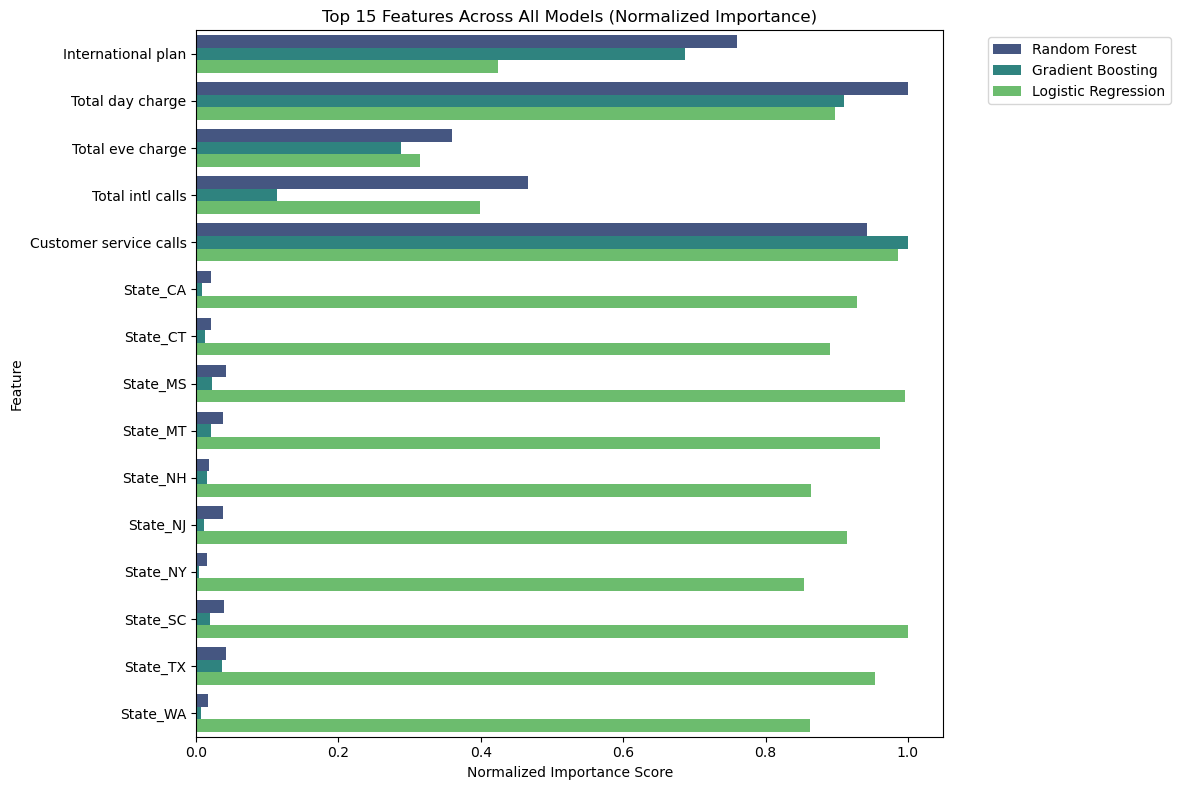

In [17]:
# Create a combined dataframe for comparison
combined_importance = pd.DataFrame({
    'Feature': X_columns,
    'Random Forest': rf_importances / rf_importances.max(),  # Normalized
    'Gradient Boosting': gb_importances / gb_importances.max(),    # Normalized
    'Logistic Regression': np.abs(lr_coefficients) / np.abs(lr_coefficients).max()  # Normalized abs coeffs
}).melt(id_vars='Feature', var_name='Model', value_name='Normalized Importance')

# Plot top features across all models
top_features = combined_importance.groupby('Feature')['Normalized Importance'].mean().nlargest(15).index
plt.figure(figsize=(12, 8))
sns.barplot(
    x='Normalized Importance', 
    y='Feature', 
    hue='Model', 
    data=combined_importance[combined_importance['Feature'].isin(top_features)],
    palette='viridis'
)
plt.title('Top 15 Features Across All Models (Normalized Importance)')
plt.xlabel('Normalized Importance Score')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

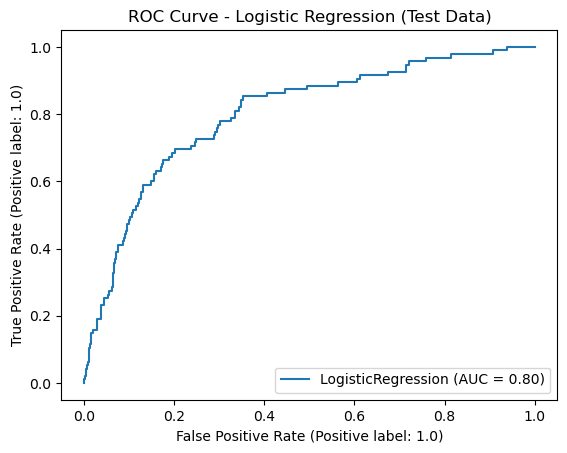

In [19]:
# Get the trained Logistic Regression model
lr_model = tuned_models_smote["Logistic Regression"]

# You can also use sklearn's built-in display
RocCurveDisplay.from_estimator(lr_model, X_test, y_test)
plt.title('ROC Curve - Logistic Regression (Test Data)')
plt.show()

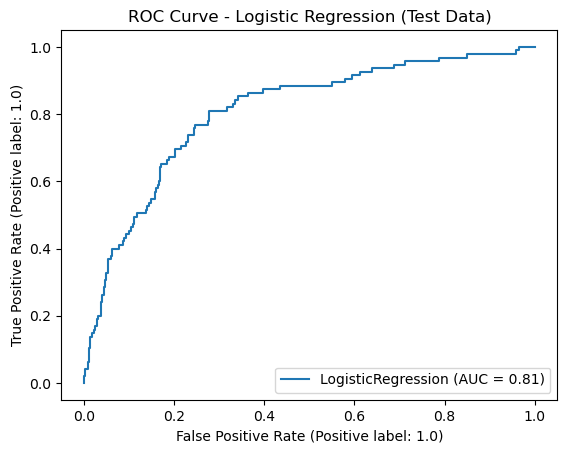

In [20]:
# Get the trained Logistic Regression model
lr_model = tuned_models_regular["Logistic Regression"]

# You can also use sklearn's built-in display
RocCurveDisplay.from_estimator(lr_model, X_test, y_test)
plt.title('ROC Curve - Logistic Regression (Test Data)')
plt.show()